<a href="https://colab.research.google.com/github/NKASHANI/Neural-Networks/blob/main/Assignment1_Applied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory

# Initialize rng
rng = np.random.default_rng(2023)

In [33]:

#I increased the batch size to maximum no of samples as recommended in the videos - when feasible:
batch_size = 315 # This is a tunable hyperparameter
shape = (64, 64) # note we are reducing the size of the image

data_dir = r'../content/drive/MyDrive/DeepLearning/Assignment1/UCMerced_LandUse/split'

train_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'train'),
                                                       seed=rng.integers(500000),
                                                       image_size=shape,
                                                       batch_size=batch_size,
                                                       label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'val'),
                                                     seed=rng.integers(500000),
                                                     image_size=shape,
                                                     batch_size=batch_size,
                                                     label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'),
                                                      seed=rng.integers(500000),
                                                      image_size=shape,
                                                      batch_size=batch_size,
                                                      label_mode='categorical')

Found 1470 files belonging to 21 classes.
Found 315 files belonging to 21 classes.
Found 315 files belonging to 21 classes.


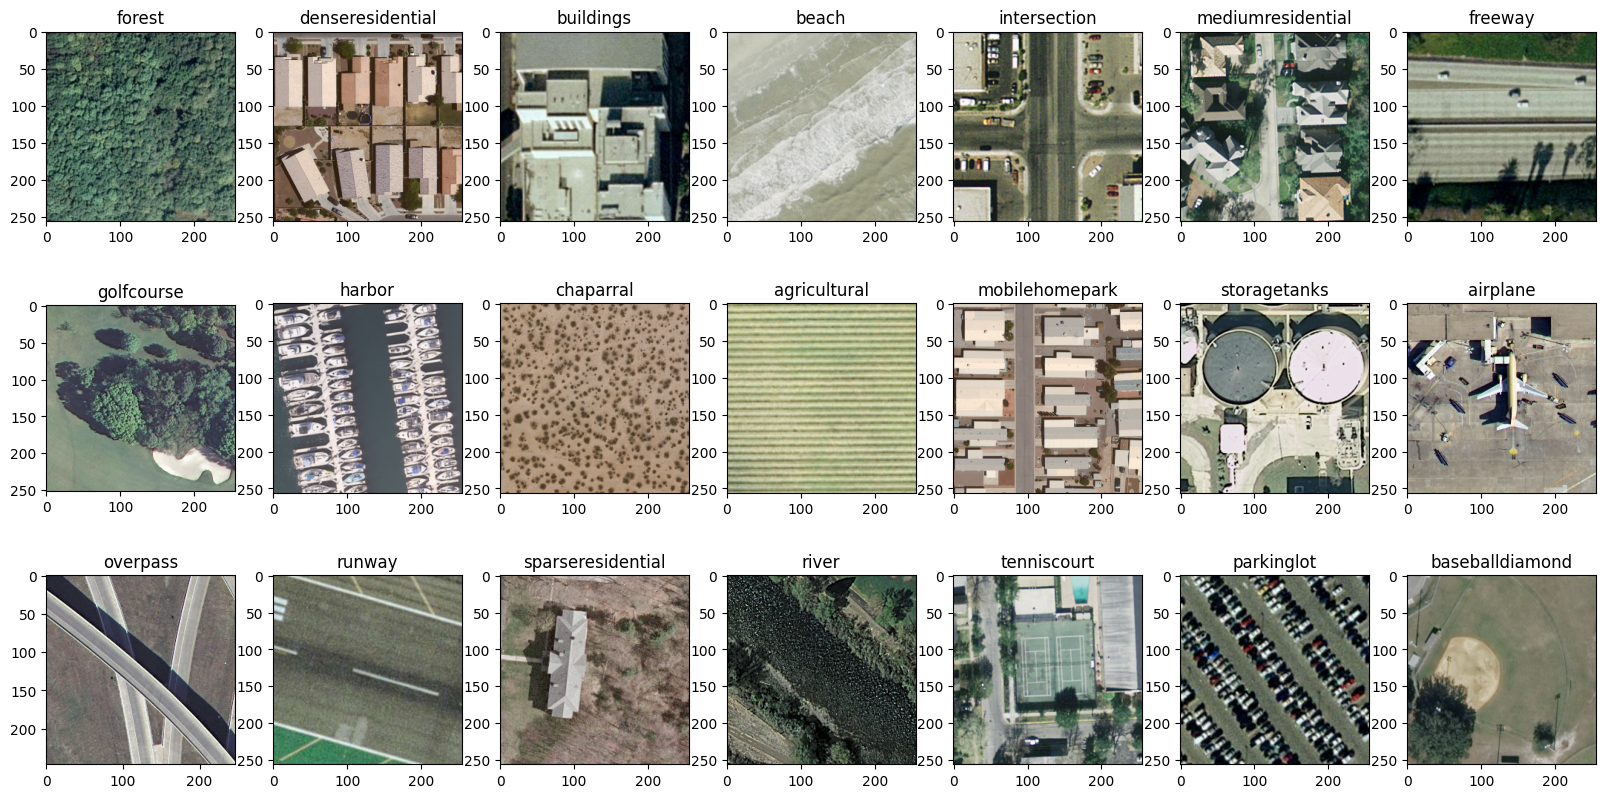

In [34]:
# Visualize some images
fig, ax = plt.subplots(3,7, figsize=(20, 10))

train_dir = os.path.join(data_dir, 'train')
i = 0
j = 0
for class_name in [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]:
  im = plt.imread(os.path.join(train_dir, class_name, os.listdir(os.path.join(train_dir, class_name))[0]))
  ax[i][j].imshow(im);
  ax[i][j].set_title(class_name);

  j += 1
  if j>6:
    j = 0
    i += 1

# Start your solution below

In [35]:
for x, y in train_ds.take(1):
    y_list = y.numpy().tolist()
    print(x.shape, y.shape)

(315, 64, 64, 3) (315, 21)


In [36]:
import keras
keras.backend.clear_session()
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)
test_ds = test_ds.map(process)


# def resize_images(images,label):
#   #tf.print('Original shape -->', tf.shape(images))
#   SIZE = (32, 32)
#   image = tf.image.resize(images, SIZE)
#   return image,label

# train_ds = train_ds.map(resize_images)
# val_ds = val_ds.map(resize_images)
# test_ds = test_ds.map(resize_images)

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming train_ds is a TensorFlow data.Dataset object
# Get the number of features from the first batch of data
for X_batch, y_batch in train_ds.take(1):
    num_features = X_batch.shape[1]

from tensorflow.keras.models import Model
# Different types of layers
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
# Optimizers
from tensorflow.keras.optimizers import SGD, Adam
# A callback API to stop training when loss does not improve any more
from tensorflow.keras.callbacks import EarlyStopping




In [38]:
!pip install -q -U keras-tuner

In [39]:
import keras_tuner as kt
import shutil
import os
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy import interp
import pandas as pd

#### Helper functions

In [40]:
#https://keras.io/guides/keras_tuner/getting_started/
def call_existing_code(units, activation, dropout, lr, num_layers):
  model = keras.Sequential()
  model.add(layers.Flatten())

  for _ in range(num_layers):
    model.add(layers.Dense(units=units, activation=activation))
    if dropout:
      model.add(layers.Dropout(rate=0.20))

  model.add(layers.Dense(21, activation="softmax"))
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=lr),
      loss="categorical_crossentropy",
      metrics=["accuracy"],
  )
  return model


def build_model(hp,layers_count,dropout=False):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh","LeakyReLU"])
    #dropout = hp.Boolean("dropout")

    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # call existing model-building code with the hyperparameter values
    model = call_existing_code(
        units=units, activation=activation, dropout=dropout, lr=lr, num_layers=layers_count
    )
    return model




def clean_hypertuning(mydir='my_dir'):
  directory = mydir
  if os.path.exists(directory):
    shutil.rmtree(directory)


#This function gets history object and plots loss for training vs. valiation
# Also plots accuracy of traning vs validation
def plot_accuracy_loss(history):
  plt.figure(figsize=(12, 5))

  #loss for training vs. valiation
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  #accuracy of traning vs validation
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()



def plot_ROC(y_list,predictions):
  y_true = pd.DataFrame(y_list).to_numpy()

  n_classes = y_true.shape[1]

  # Initialize variables for the ROC curve
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  # Calculate ROC curve and AUC for each class
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute all-fpr and average tpr for the average ROC curve
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])
  mean_tpr /= n_classes

  # Compute average ROC curve and AUC
  fpr["avg"] = all_fpr
  tpr["avg"] = mean_tpr
  roc_auc["avg"] = auc(fpr["avg"], tpr["avg"])

  # Plot the ROC curve
  plt.figure(figsize=(10, 8))

  # Plot average ROC curve
  plt.plot(fpr["avg"], tpr["avg"], color='b', linestyle='--', linewidth=4, label='Average ROC curve (area = {0:0.2f})'.format(roc_auc["avg"]))

  colors = plt.cm.get_cmap('viridis', n_classes)
  for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], color=colors(i / n_classes), lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()









### **(a) MLP with one hidden layer**


### Hypertuning

For each of the following neural network configurations,

(a) Tune hyperparameters (using any method other than grid search) and list the best set of hyperparameters.

(b) Try at least 3 different activation functions and report results for all of them.

(c) Plot training and validation loss curves along with a plot of training and validation accuracy vs.
epoch. Comment on the loss curves.

(d) Plot ROC curves using the test set. Which is the best configuration in your experiments?

(e) Comment on your results based on the number of parameters, choice of activation function, time required to train the models, overfitting/underfitting, and why you think some models are performing better than others.
Neural network configurations:

In [41]:
#create arguments for model, here I am using Relu as activation and 1 layer
build_model_with_args = partial(build_model, layers_count=1)

#Clean previous hypertuning data
clean_hypertuning()


tuner = kt.Hyperband(build_model_with_args,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir')


es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=5,
                   restore_best_weights=True)

tuner.search(train_ds,
             epochs=50,
             validation_data=val_ds,
             callbacks=[es])

# Get the optimal hyperparameters
best_hps_a=tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.09841269999742508

Best val_accuracy So Far: 0.22539682686328888
Total elapsed time: 00h 03m 35s


In [42]:

print(f"""
The hyperparameter search is complete. The optimal number of units in each
layer is {best_hps_a.get('units')} and the optimal learning rate for the optimizer
is {best_hps_a.get('lr')}, activation function used {best_hps_a.get('activation')}.
""")


The hyperparameter search is complete. The optimal number of units in each
layer is 256 and the optimal learning rate for the optimizer
is 0.0001545783809235739, activation function used tanh.



In [43]:
# Build the model with the optimal hyperparameters and train it on the data
best_model = tuner.hypermodel.build(best_hps_a)
history = best_model.fit(train_ds, epochs=20, validation_data=val_ds)
#run prediction
predictions = best_model.predict(test_ds)

Epoch 1/20
5/5 [==============================] - 2s 107ms/step - loss: 3.9575 - accuracy: 0.0490 - val_loss: 3.5563 - val_accuracy: 0.0667
Epoch 2/20
5/5 [==============================] - 2s 84ms/step - loss: 3.3709 - accuracy: 0.0673 - val_loss: 3.1562 - val_accuracy: 0.0635
Epoch 3/20
5/5 [==============================] - 2s 77ms/step - loss: 3.0830 - accuracy: 0.0789 - val_loss: 3.0301 - val_accuracy: 0.1079
Epoch 4/20
5/5 [==============================] - 1s 84ms/step - loss: 2.9595 - accuracy: 0.0959 - val_loss: 2.9585 - val_accuracy: 0.1397
Epoch 5/20
5/5 [==============================] - 2s 93ms/step - loss: 2.9103 - accuracy: 0.1497 - val_loss: 2.9345 - val_accuracy: 0.1175
Epoch 6/20
5/5 [==============================] - 2s 96ms/step - loss: 2.8650 - accuracy: 0.1782 - val_loss: 2.9003 - val_accuracy: 0.1810
Epoch 7/20
5/5 [==============================] - 2s 94ms/step - loss: 2.8170 - accuracy: 0.2299 - val_loss: 2.8851 - val_accuracy: 0.1619
Epoch 8/20
5/5 [==========

1/1 [==============================] - 0s 300ms/step


#### 1 Layer Model - Activation Relu : Loss & Accuracy

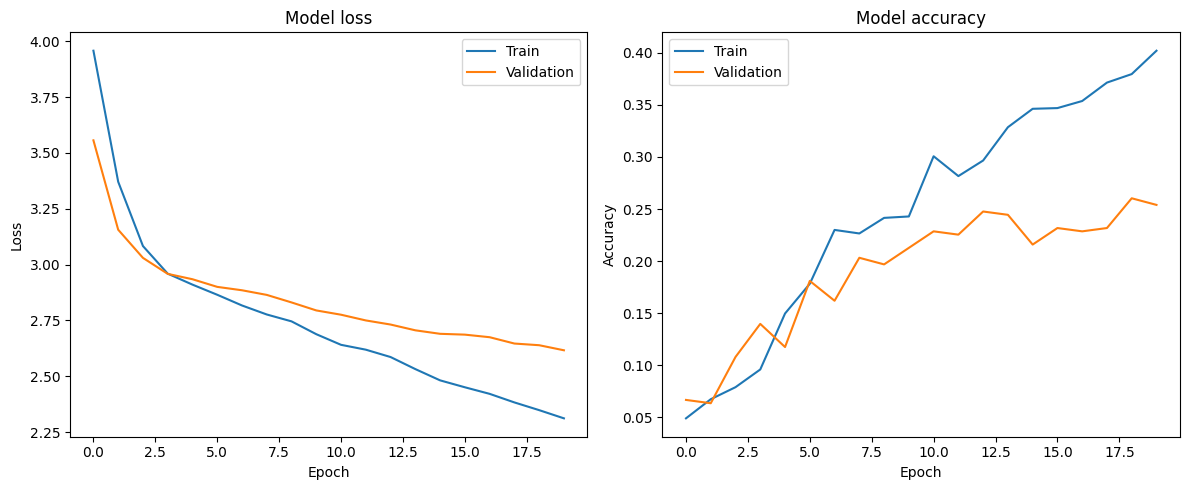

In [44]:
plot_accuracy_loss(history)

<ipython-input-40-da2e1612f9ca>:88: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
<ipython-input-40-da2e1612f9ca>:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


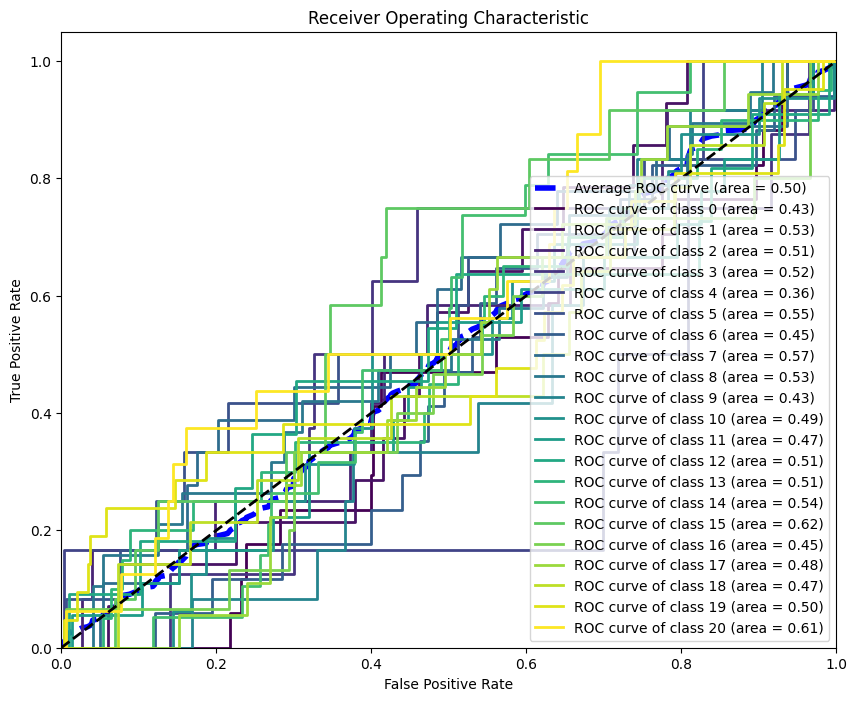

In [45]:
plot_ROC(y_list,predictions)

### **(b) MLP with two hidden layers**


In [46]:
#create arguments for model, here I am using Relu as activation and 1 layer

#Clean previous hypertuning data
clean_hypertuning()

build_model_with_args = partial(build_model, layers_count=2)





tuner = kt.Hyperband(build_model_with_args,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir')


es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=5,
                   restore_best_weights=True)

tuner.search(train_ds,
             epochs=50,
             validation_data=val_ds,
             callbacks=[es])

# Get the optimal hyperparameters
best_hps_two_layers = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in each
layer is {best_hps_two_layers.get('units')} and the optimal learning rate for the optimizer
is {best_hps_two_layers.get('lr')}, activation function used {best_hps_two_layers.get('activation')}.
""")

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.0476190485060215

Best val_accuracy So Far: 0.19682539999485016
Total elapsed time: 00h 03m 47s

The hyperparameter search is complete. The optimal number of units in each
layer is 256 and the optimal learning rate for the optimizer
is 0.00013611464942586763, activation function used relu.



In [47]:


# Build the model with the optimal hyperparameters and train it on the data
best_model_two_layers = tuner.hypermodel.build(best_hps_two_layers)
history_two_layers = best_model_two_layers.fit(train_ds, epochs=50, validation_data=val_ds)
#run prediction
predictions_two_layers = best_model_two_layers.predict(test_ds)

Epoch 1/50
5/5 [==============================] - 3s 102ms/step - loss: 3.1362 - accuracy: 0.0463 - val_loss: 3.0669 - val_accuracy: 0.0413
Epoch 2/50
5/5 [==============================] - 1s 76ms/step - loss: 3.0443 - accuracy: 0.0687 - val_loss: 3.0244 - val_accuracy: 0.0667
Epoch 3/50
5/5 [==============================] - 1s 76ms/step - loss: 3.0072 - accuracy: 0.0626 - val_loss: 3.0161 - val_accuracy: 0.0698
Epoch 4/50
5/5 [==============================] - 1s 78ms/step - loss: 2.9861 - accuracy: 0.0707 - val_loss: 2.9904 - val_accuracy: 0.0794
Epoch 5/50
5/5 [==============================] - 1s 78ms/step - loss: 2.9372 - accuracy: 0.0884 - val_loss: 2.9671 - val_accuracy: 0.1048
Epoch 6/50
5/5 [==============================] - 1s 79ms/step - loss: 2.9154 - accuracy: 0.1578 - val_loss: 2.9421 - val_accuracy: 0.1460
Epoch 7/50
5/5 [==============================] - 1s 73ms/step - loss: 2.8692 - accuracy: 0.1510 - val_loss: 2.9126 - val_accuracy: 0.1556
Epoch 8/50
5/5 [==========

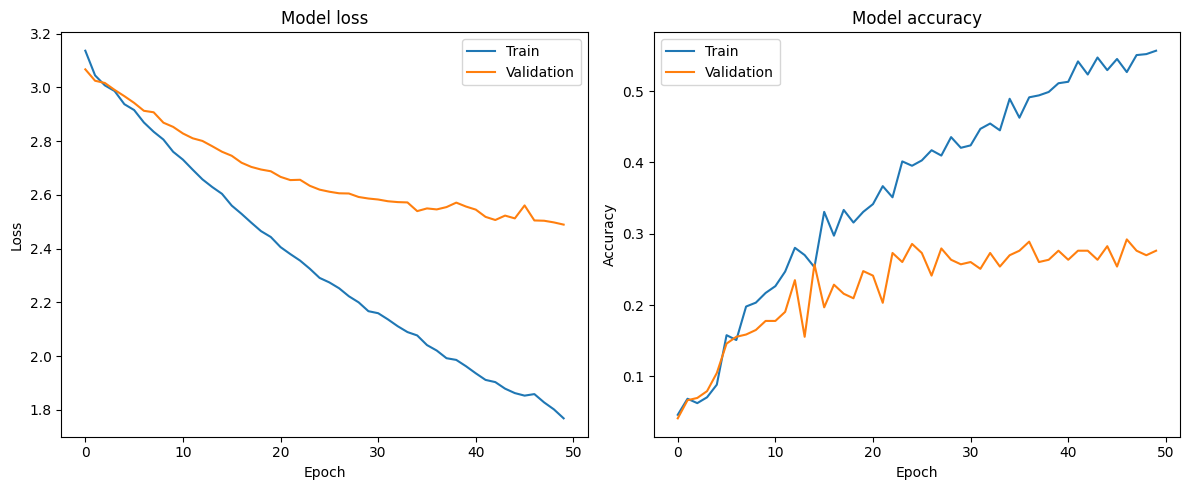

In [48]:
plot_accuracy_loss(history_two_layers)

Run again with 20 epochs this time :

In [49]:

# Build the model with the optimal hyperparameters and train it on the data
history_two_layers = best_model_two_layers.fit(train_ds, epochs=20, validation_data=val_ds)
#run prediction
predictions_two_layers = best_model_two_layers.predict(test_ds)

Epoch 1/20
5/5 [==============================] - 1s 84ms/step - loss: 1.7510 - accuracy: 0.5707 - val_loss: 2.4790 - val_accuracy: 0.2857
Epoch 2/20
5/5 [==============================] - 1s 84ms/step - loss: 1.7424 - accuracy: 0.5667 - val_loss: 2.5122 - val_accuracy: 0.2667
Epoch 3/20
5/5 [==============================] - 2s 88ms/step - loss: 1.7227 - accuracy: 0.5912 - val_loss: 2.4954 - val_accuracy: 0.2984
Epoch 4/20
5/5 [==============================] - 2s 81ms/step - loss: 1.7086 - accuracy: 0.5816 - val_loss: 2.4916 - val_accuracy: 0.2635
Epoch 5/20
5/5 [==============================] - 1s 81ms/step - loss: 1.6901 - accuracy: 0.5959 - val_loss: 2.4725 - val_accuracy: 0.2952
Epoch 6/20
5/5 [==============================] - 1s 77ms/step - loss: 1.6742 - accuracy: 0.5952 - val_loss: 2.5029 - val_accuracy: 0.2635
Epoch 7/20
5/5 [==============================] - 1s 78ms/step - loss: 1.6644 - accuracy: 0.6082 - val_loss: 2.5046 - val_accuracy: 0.2603
Epoch 8/20
5/5 [===========

<ipython-input-40-da2e1612f9ca>:88: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
<ipython-input-40-da2e1612f9ca>:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


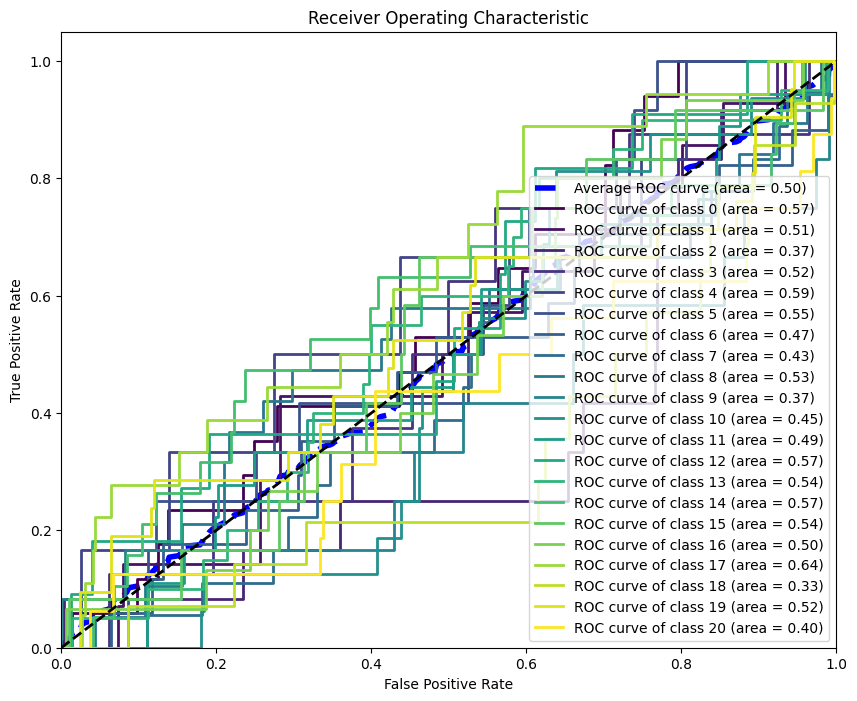

In [50]:
plot_ROC(y_list,predictions_two_layers)

### **(c) MLP with two hidden layers and dropout after each of the two hidden layers.**

In [52]:
#create arguments for model, here I am using Relu as activation and 1 layer

#Clean previous hypertuning data
clean_hypertuning()

build_model_with_args = partial(build_model, layers_count=2,dropout=True)





tuner = kt.Hyperband(build_model_with_args,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir')


es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=5,
                   restore_best_weights=True)

tuner.search(train_ds,
             epochs=50,
             validation_data=val_ds,
             callbacks=[es])

# Get the optimal hyperparameters
best_hps_two_layers_dout = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in each
layer is {best_hps_two_layers_dout.get('units')} and the optimal learning rate for the optimizer
is {best_hps_two_layers_dout.get('lr')}, activation function used {best_hps_two_layers_dout.get('activation')}.
""")

Trial 30 Complete [00h 00m 18s]
val_accuracy: 0.19682539999485016

Best val_accuracy So Far: 0.20952381193637848
Total elapsed time: 00h 04m 02s

The hyperparameter search is complete. The optimal number of units in each
layer is 160 and the optimal learning rate for the optimizer
is 0.0006060757455355893, activation function used LeakyReLU.



In [55]:


# Build the model with the optimal hyperparameters and train it on the data
best_hps_two_layers_dout = tuner.hypermodel.build(best_hps_two_layers)
history_two_layers_dout = best_hps_two_layers_dout.fit(train_ds, epochs=50, validation_data=val_ds)
#run prediction
predictions_two_layers_dout = best_hps_two_layers_dout.predict(test_ds)

Epoch 1/50
5/5 [==============================] - 3s 110ms/step - loss: 3.1967 - accuracy: 0.0422 - val_loss: 3.0643 - val_accuracy: 0.0571
Epoch 2/50
5/5 [==============================] - 2s 79ms/step - loss: 3.0802 - accuracy: 0.0503 - val_loss: 3.0311 - val_accuracy: 0.0571
Epoch 3/50
5/5 [==============================] - 1s 78ms/step - loss: 3.0460 - accuracy: 0.0524 - val_loss: 3.0266 - val_accuracy: 0.0762
Epoch 4/50
5/5 [==============================] - 2s 178ms/step - loss: 3.0097 - accuracy: 0.0782 - val_loss: 3.0199 - val_accuracy: 0.0571
Epoch 5/50
5/5 [==============================] - 2s 78ms/step - loss: 2.9965 - accuracy: 0.0707 - val_loss: 3.0074 - val_accuracy: 0.1206
Epoch 6/50
5/5 [==============================] - 1s 78ms/step - loss: 2.9819 - accuracy: 0.0973 - val_loss: 2.9898 - val_accuracy: 0.1238
Epoch 7/50
5/5 [==============================] - 1s 79ms/step - loss: 2.9692 - accuracy: 0.1211 - val_loss: 2.9760 - val_accuracy: 0.1143
Epoch 8/50
5/5 [=========

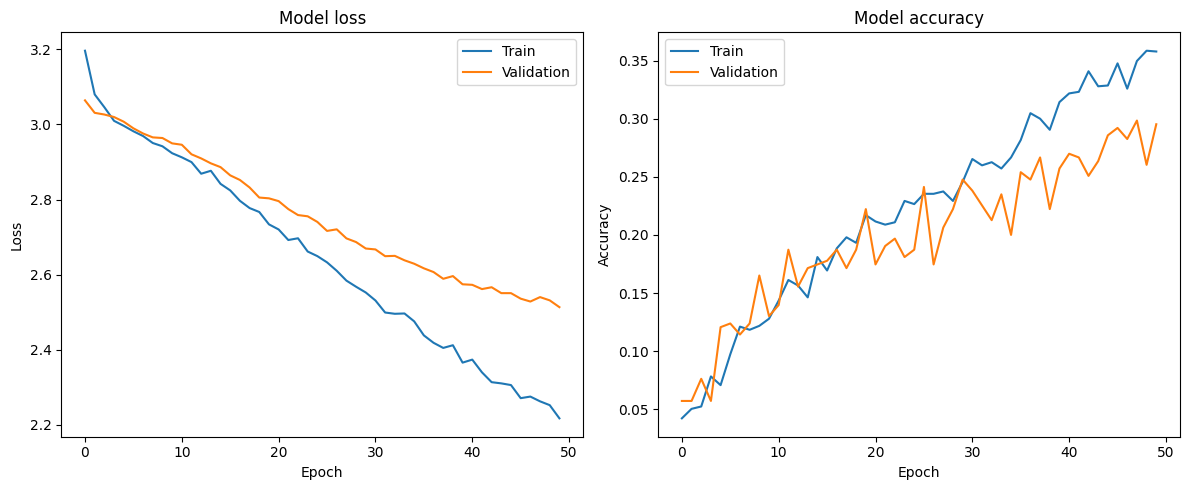

In [56]:
plot_accuracy_loss(history_two_layers_dout)

<ipython-input-40-da2e1612f9ca>:88: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
<ipython-input-40-da2e1612f9ca>:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_classes)


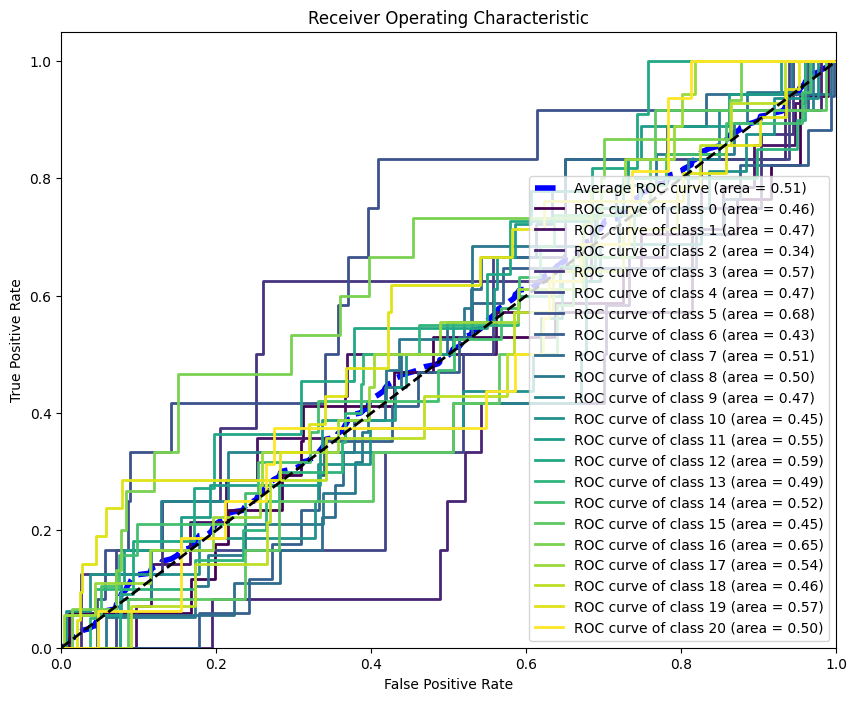

In [57]:
plot_ROC(y_list,predictions_two_layers_dout)

### **(d) MLP with two hidden layers and batch normalization and dropout after each of the two hidden layers.**

### **(e) Your choice of MLP. Be creative with your architecture!**

In [51]:
#https://github.com/keras-team/keras-tuner/issues/122
# class MyHyperModel(kt.HyperModel):
#     def build(self, hp):
#         model = keras.Sequential()
#         model.add(layers.Flatten())
#         model.add(
#             layers.Dense(
#                 units=hp.Int("units", min_value=32, max_value=512, step=32),
#                 activation="relu",
#             )
#         )
#         model.add(layers.Dense(10, activation="softmax"))
#         model.compile(
#             optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
#         )
#         return model

#     def fit(self, hp, model, *args, **kwargs):
#         return model.fit(
#             *args,
#             batch_size=hp.Choice("batch_size", [16, 32]),
#             **kwargs,
#         )

# tuner = kt.RandomSearch(
#     MyHyperModel(),
#     objective="val_accuracy",
#     max_trials=3,
#     overwrite=True,
#     directory="my_dir",
#     project_name="tune_hypermodel",
# )